<a href="https://colab.research.google.com/github/Himakar06/Employee_Attrition/blob/main/notebooks/Employee_Attrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv('HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [6]:
print("shape :",df.shape)
print("Duplicate values : ",df.duplicated().any())

shape : (1470, 35)
Duplicate values :  False


In [7]:
categorical_columns = df.select_dtypes(include=['object','category']).columns.tolist()
numerical_columns = df.select_dtypes(include='int64').columns.tolist()

max_len = max(len(categorical_columns),len(numerical_columns))

categorical_columns += [' '] * (max_len-len(categorical_columns))
combined_df = pd.DataFrame({
    "Categorical Columns" : categorical_columns,
    "Numerical Columns" : numerical_columns
})
combined_df

,Categorical Columns,Numerical Columns
0,Attrition,Age
1,BusinessTravel,DailyRate
2,Department,DistanceFromHome
3,EducationField,Education
4,Gender,EmployeeCount
5,JobRole,EmployeeNumber
6,MaritalStatus,EnvironmentSatisfaction
7,Over18,HourlyRate
8,OverTime,JobInvolvement
9,,JobLevel


In [8]:
#Distribution of Numerical features

df['Age'].describe().T

,Age
count,1470.000000
mean,36.923810
std,9.135373
min,18.000000
25%,30.000000
50%,36.000000
75%,43.000000
max,60.000000


In [9]:
#frequency of categorical features
df['BusinessTravel'].value_counts()

,count
BusinessTravel,
Travel_Rarely,1043
Travel_Frequently,277
Non-Travel,150


In [10]:
numerical_columns = [col for col in numerical_columns if col != 'Attrition']
print(numerical_columns)
feature = input("Enter the feature : ")
if feature in numerical_columns:
  plt.figure(figsize=(6,4))
  fig = px.histogram(df, x=feature, color='Attrition', title= f"Interactive Histogram for {feature} vs Attrition", barmode= 'overlay', nbins = 40)
  fig.show()
else:
  print("\nEnter a feature from the numerical category")

['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Enter the feature : DistanceFromHome


<Figure size 600x400 with 0 Axes>

In [11]:
df.groupby("Attrition")[numerical_columns].mean().T

Attrition,No,Yes
Age,37.561233,33.607595
DailyRate,812.504461,750.362869
DistanceFromHome,8.915653,10.632911
Education,2.927007,2.839662
EmployeeCount,1.000000,1.000000
EmployeeNumber,1027.656123,1010.345992
EnvironmentSatisfaction,2.771290,2.464135
HourlyRate,65.952149,65.573840
JobInvolvement,2.770479,2.518987
JobLevel,2.145985,1.637131


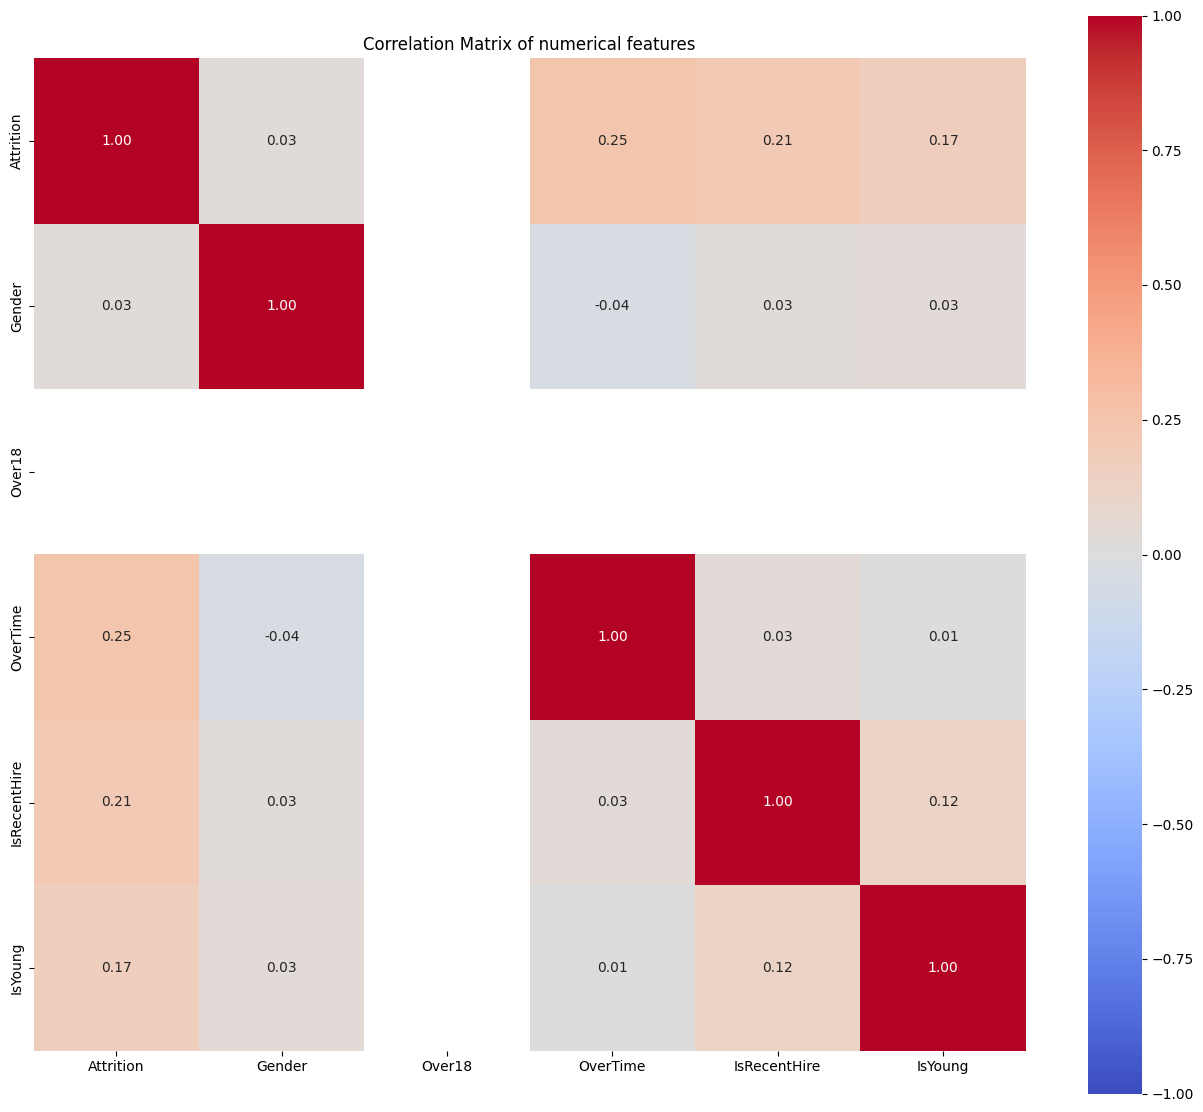

In [18]:
#Correlation Matrix for numerical features
numerical_features = df.select_dtypes(include='int64')
correlation_matrix = numerical_features.corr()
plt.figure(figsize=(16,14))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Correlation Matrix of numerical features")
plt.show()

In [19]:
#Feature Engineering
df['SatisfactionScore'] = (df['JobSatisfaction'] + df['EnvironmentSatisfaction'] + df['RelationshipSatisfaction'])/3
df['IsRecentHire'] = (df['YearsAtCompany']<2).astype(int)
df['IsYoung'] = (df['Age']<30).astype(int)

In [20]:
#Scale numerical features (StandardScaler or MinMaxScaler)
exclude_cols = le_features
exclude_cols = list(set(exclude_cols))

other_numeric_cols = [col for col in numerical_features if col not in exclude_cols]

scaler = MinMaxScaler()
df[other_numeric_cols] = scaler.fit_transform(df[other_numeric_cols])

df[other_numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
IsRecentHire,1470.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IsYoung,1470.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X = df.drop('Attrition',axis=1)
y = df['Attrition']

In [22]:
#Compare models and select best performer
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    acc = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy').mean()
    f1 = cross_val_score(pipeline, X, y, cv=skf, scoring='f1').mean()
    roc = cross_val_score(pipeline, X, y, cv=skf, scoring='roc_auc').mean()

    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'F1 Score': round(f1, 4),
        'ROC AUC': round(roc, 4)
    })

results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
print(results_df)

                 Model  Accuracy  F1 Score  ROC AUC
0  Logistic Regression    0.7565    0.4872   0.8179
2    Gradient Boosting    0.8667    0.4716   0.8056
3                  SVM    0.8374    0.4594   0.7772
5              XGBoost    0.8585    0.4477   0.8053
1        Random Forest    0.8619    0.3972   0.8077
4                  KNN    0.6320    0.3603   0.6789


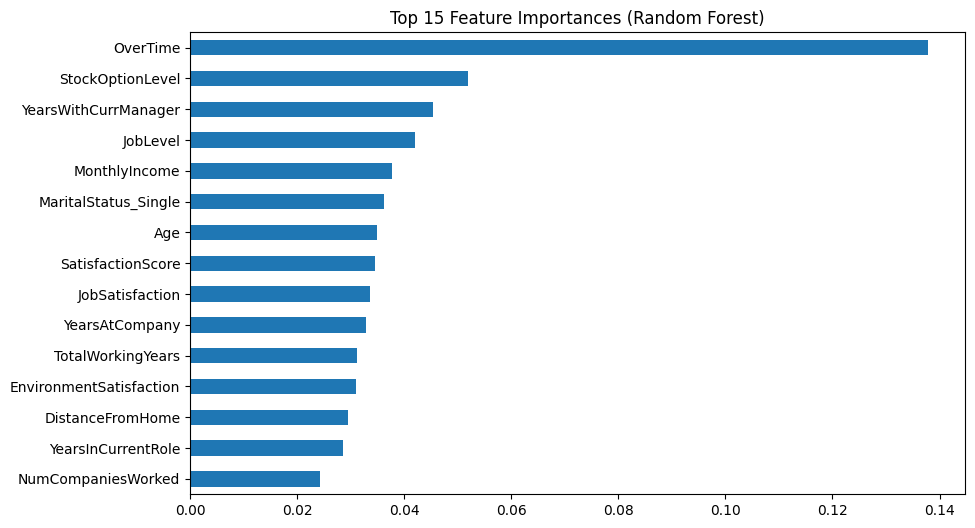

In [23]:
# Train best model (example: Random Forest here)
best_model_name = 'Random Forest'
best_model = models[best_model_name]

# Fit pipeline manually on entire data
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', best_model)
])

pipeline.fit(X, y)

# Get feature names after preprocessing (assume no column changes after scaling/SMOTE)
feature_names = X.columns

# Extract feature importances
if hasattr(best_model, 'feature_importances_'):
    importances = pipeline.named_steps['classifier'].feature_importances_
    importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)
elif hasattr(best_model, 'coef_'):
    importances = pipeline.named_steps['classifier'].coef_[0]
    importance_df = pd.Series(importances, index=feature_names).sort_values(key=abs, ascending=False)
else:
    print("Model does not support feature importances.")
    importance_df = None

# Plot
if importance_df is not None:
    plt.figure(figsize=(10, 6))
    importance_df.head(15).plot(kind='barh')
    plt.title(f"Top 15 Feature Importances ({best_model_name})")
    plt.gca().invert_yaxis()
    plt.show()


 Hold-Out Test Set Evaluation:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0

📄 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       247
           1       1.00      1.00      1.00        47

    accuracy                           1.00       294
   macro avg       1.00      1.00      1.00       294
weighted avg       1.00      1.00      1.00       294



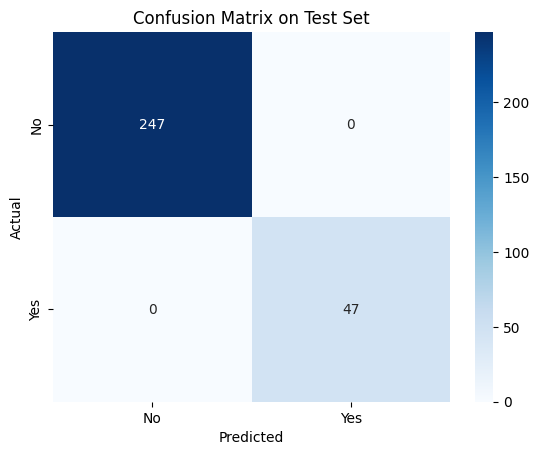

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]  # For ROC AUC


print(" Hold-Out Test Set Evaluation:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall:", round(recall_score(y_test, y_pred), 4))
print("F1 Score:", round(f1_score(y_test, y_pred), 4))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))

# Classification report
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()


In [33]:
import joblib
joblib.dump(pipeline, "employee_attrition_model.csv")


['employee_attrition_model.csv']